In [1]:
%%capture
! sudo apt-get install aria2

In [2]:
!aria2c -x 10 -j 10 http://images.cocodataset.org/zips/train2017.zip
!aria2c -x 10 -j 10 http://images.cocodataset.org/zips/val2017.zip
!aria2c -x 10 -j 10 http://images.cocodataset.org/annotations/annotations_trainval2017.zip
!unzip *.zip



02/05 08:10:13 [NOTICE] Downloading 1 item(s)
 *** Download Progress Summary as of Sun Feb  5 08:11:13 2023 *** 
=
[#c8cff3 7.7GiB/18GiB(43%) CN:5 DL:97MiB ETA:1m47s]
FILE: /content/train2017.zip
-

 *** Download Progress Summary as of Sun Feb  5 08:12:14 2023 *** 
=
[#c8cff3 13GiB/18GiB(73%) CN:5 DL:95MiB ETA:51s]
FILE: /content/train2017.zip
-

 *** Download Progress Summary as of Sun Feb  5 08:13:15 2023 *** 
=
[#c8cff3 17GiB/18GiB(99%) CN:2 DL:77MiB]
FILE: /content/train2017.zip
-


02/05 08:13:17 [NOTICE] Download complete: /content/train2017.zip

Download Results:
gid   |stat|avg speed  |path/URI
======+====+===========+=======================================================
c8cff3|OK  |   100MiB/s|/content/train2017.zip

Status Legend:
(OK):download completed.

02/05 08:13:17 [NOTICE] Downloading 1 item(s)

02/05 08:13:28 [NOTICE] Download complete: /content/val2017.zip

Download Results:
gid   |stat|avg speed  |path/URI
======+====+===========+=================================

In [3]:
!unzip /content/train2017.zip
!unzip /content/val2017.zip
!unzip /content/annotations_trainval2017.zip



Streaming output truncated to the last 5000 lines.
 extracting: val2017/000000365745.jpg  
 extracting: val2017/000000320425.jpg  
 extracting: val2017/000000481404.jpg  
 extracting: val2017/000000314294.jpg  
 extracting: val2017/000000335328.jpg  
 extracting: val2017/000000513688.jpg  
 extracting: val2017/000000158548.jpg  
 extracting: val2017/000000132116.jpg  
 extracting: val2017/000000415238.jpg  
 extracting: val2017/000000321333.jpg  
 extracting: val2017/000000081738.jpg  
 extracting: val2017/000000577584.jpg  
 extracting: val2017/000000346905.jpg  
 extracting: val2017/000000433980.jpg  
 extracting: val2017/000000228144.jpg  
 extracting: val2017/000000041872.jpg  
 extracting: val2017/000000117492.jpg  
 extracting: val2017/000000368900.jpg  
 extracting: val2017/000000376900.jpg  
 extracting: val2017/000000352491.jpg  
 extracting: val2017/000000330790.jpg  
 extracting: val2017/000000384850.jpg  
 extracting: val2017/000000032735.jpg  
 extracting: val2017/00000019

In [4]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torchvision.models import resnet18,resnet50, ResNet50_Weights
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils import data
import torchvision.models as models



In [5]:
class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        super(EncoderCNN, self).__init__()
        resnet = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
        for param in resnet.parameters():
            param.requires_grad_(False)
        
        modules = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)
        self.embed = nn.Linear(resnet.fc.in_features, embed_size)

    def forward(self, images):
        features = self.resnet(images)
        features = features.view(features.size(0), -1)
        features = self.embed(features)
        return features
    

class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=1):
        super().__init__()
        self.word_embedding_layer = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM( input_size = embed_size, 
                             hidden_size = hidden_size, 
                             num_layers = num_layers, 
                             dropout = 0, 
                             batch_first=True
                           )
        
        self.linear_fc = nn.Linear(hidden_size, vocab_size)
    
    def forward(self, features, captions):
        captions = captions[:, :-1] 
        captions = self.word_embedding_layer(captions)
        inputs = torch.cat((features.unsqueeze(1), captions), dim=1)
        outputs, _ = self.lstm(inputs)
        outputs = self.linear_fc(outputs)
        
        return outputs

    def sample(self, inputs, states=None, max_len=20):
        " accepts pre-processed image tensor (inputs) and returns predicted sentence (list of tensor ids of length max_len)"
        outputs = []   
        output_length = 0
        
        while (output_length != max_len+1):

            output, states = self.lstm(inputs,states)
            output = self.linear_fc(output.squeeze(dim = 1))
            _, predicted_index = torch.max(output, 1)
            
            outputs.append(predicted_index.cpu().numpy()[0].item())
            
            if (predicted_index == 1):
                break
            
            inputs = self.word_embedding_layer(predicted_index)   
            inputs = inputs.unsqueeze(1)
            
            output_length += 1

        return outputs

In [6]:
import nltk
import pickle
import os.path
from pycocotools.coco import COCO
from collections import Counter

class Vocabulary(object):

    def __init__(self,
        vocab_threshold,
        vocab_file='./vocab.pkl',
        start_word="<start>",
        end_word="<end>",
        unk_word="<unk>",
        annotations_file='/content/annotations/captions_train2017.json',
        vocab_from_file=False):
        """Initialize the vocabulary.
        Args:
          vocab_threshold: Minimum word count threshold.
          vocab_file: File containing the vocabulary.
          start_word: Special word denoting sentence start.
          end_word: Special word denoting sentence end.
          unk_word: Special word denoting unknown words.
          annotations_file: Path for train annotation file.
          vocab_from_file: If False, create vocab from scratch & override any existing vocab_file
                           If True, load vocab from from existing vocab_file, if it exists
        """
        self.vocab_threshold = vocab_threshold
        self.vocab_file = vocab_file
        self.start_word = start_word
        self.end_word = end_word
        self.unk_word = unk_word
        self.annotations_file = annotations_file
        self.vocab_from_file = vocab_from_file
        self.get_vocab()

    def get_vocab(self):
        """Load the vocabulary from file OR build the vocabulary from scratch."""
        if os.path.exists(self.vocab_file) & self.vocab_from_file:
            with open(self.vocab_file, 'rb') as f:
                vocab = pickle.load(f)
                self.word2idx = vocab.word2idx
                self.idx2word = vocab.idx2word
            print('Vocabulary successfully loaded from vocab.pkl file!')
        else:
            self.build_vocab()
            with open(self.vocab_file, 'wb') as f:
                pickle.dump(self, f)
        
    def build_vocab(self):
        """Populate the dictionaries for converting tokens to integers (and vice-versa)."""
        self.init_vocab()
        self.add_word(self.start_word)
        self.add_word(self.end_word)
        self.add_word(self.unk_word)
        self.add_captions()

    def init_vocab(self):
        """Initialize the dictionaries for converting tokens to integers (and vice-versa)."""
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0

    def add_word(self, word):
        """Add a token to the vocabulary."""
        if not word in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1

    def add_captions(self):
        """Loop over training captions and add all tokens to the vocabulary that meet or exceed the threshold."""
        coco = COCO(self.annotations_file)
        counter = Counter()
        ids = coco.anns.keys()
        for i, id in enumerate(ids):
            caption = str(coco.anns[id]['caption'])
            tokens = nltk.tokenize.word_tokenize(caption.lower())
            counter.update(tokens)

            if i % 100000 == 0:
                print("[%d/%d] Tokenizing captions..." % (i, len(ids)))

        words = [word for word, cnt in counter.items() if cnt >= self.vocab_threshold]

        for i, word in enumerate(words):
            self.add_word(word)

    def __call__(self, word):
        if not word in self.word2idx:
            return self.word2idx[self.unk_word]
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)

In [7]:
!git clone https://github.com/cocodataset/cocoapi.git

Cloning into 'cocoapi'...
remote: Enumerating objects: 975, done.
remote: Total 975 (delta 0), reused 0 (delta 0), pack-reused 975
Receiving objects: 100% (975/975), 11.72 MiB | 19.09 MiB/s, done.
Resolving deltas: 100% (576/576), done.


In [8]:
import os
import sys
sys.path.append('/content/cocoapi/PythonAPI')
from pycocotools.coco import COCO

# initialize COCO API for instance annotations
dataDir = '/content'
dataType = 'val2017'
instances_annFile = os.path.join(dataDir, 'annotations/instances_{}.json'.format(dataType))
coco = COCO(instances_annFile)

# initialize COCO API for caption annotations
captions_annFile = os.path.join(dataDir, 'annotations/captions_{}.json'.format(dataType))
coco_caps = COCO(captions_annFile)

# get image ids 
ids = list(coco.anns.keys())

loading annotations into memory...
Done (t=0.66s)
creating index...
index created!
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!


http://images.cocodataset.org/val2017/000000307598.jpg


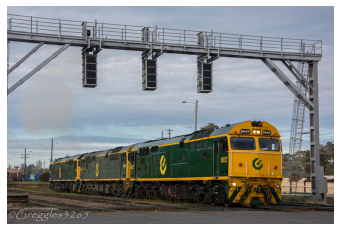

In [9]:
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
%matplotlib inline

# pick a random image and obtain the corresponding URL
ann_id = np.random.choice(ids)
img_id = coco.anns[ann_id]['image_id']
img = coco.loadImgs(img_id)[0]
url = img['coco_url']

# print URL and visualize corresponding image
print(url)
I = io.imread(url)
plt.axis('off')
plt.imshow(I)
plt.show()

# load and display captions
annIds = coco_caps.getAnnIds(imgIds=img['id']);
anns = coco_caps.loadAnns(annIds)
coco_caps.showAnns(anns)

In [10]:
def get_loader(transform,
               mode='train',
               batch_size=1,
               vocab_threshold=None,
               vocab_file='./vocab.pkl',
               start_word="<start>",
               end_word="<end>",
               unk_word="<unk>",
               vocab_from_file=True,
               num_workers=0,
               cocoapi_loc='/opt'):
   
    assert mode in ['train', 'test'], "mode must be one of 'train' or 'test'."
    if vocab_from_file==False: assert mode=='train', "To generate vocab from captions file, must be in training mode (mode='train')."

    # Based on mode (train, val, test), obtain img_folder and annotations_file.
    if mode == 'train':
        if vocab_from_file==True: assert os.path.exists(vocab_file), "vocab_file does not exist.  Change vocab_from_file to False to create vocab_file."
        img_folder = os.path.join(cocoapi_loc, '/content/train2017')
        annotations_file = os.path.join(cocoapi_loc, '/content/annotations/captions_train2017.json')
    if mode == 'test':
        assert batch_size==1, "Please change batch_size to 1 if testing your model."
        assert os.path.exists(vocab_file), "Must first generate vocab.pkl from training data."
        assert vocab_from_file==True, "Change vocab_from_file to True."
        img_folder = os.path.join(cocoapi_loc, '/content/val2017')
        annotations_file = os.path.join(cocoapi_loc, '/content/annotations/captions_val2017.json')

    # COCO caption dataset.
    dataset = CoCoDataset(transform=transform,
                          mode=mode,
                          batch_size=batch_size,
                          vocab_threshold=vocab_threshold,
                          vocab_file=vocab_file,
                          start_word=start_word,
                          end_word=end_word,
                          unk_word=unk_word,
                          annotations_file=annotations_file,
                          vocab_from_file=vocab_from_file,
                          img_folder=img_folder)

    if mode == 'train':
        # Randomly sample a caption length, and sample indices with that length.
        indices = dataset.get_train_indices()
        # Create and assign a batch sampler to retrieve a batch with the sampled indices.
        initial_sampler = data.sampler.SubsetRandomSampler(indices=indices)
        # data loader for COCO dataset.
        data_loader = data.DataLoader(dataset=dataset, 
                                      num_workers=num_workers,
                                      batch_sampler=data.sampler.BatchSampler(sampler=initial_sampler,
                                                                              batch_size=dataset.batch_size,
                                                                              drop_last=False))
    else:
        data_loader = data.DataLoader(dataset=dataset,
                                      batch_size=dataset.batch_size,
                                      shuffle=True,
                                      num_workers=num_workers)

    return data_loader


a yellow and green train, at stop lights.
A commuter train that is in the train yard and is parked. 
A yellow and green train traveling under signals.
A green and yellow train is driving on the track.
A yellow and green train is coming down the track.


In [11]:
from PIL import Image
import json
class CoCoDataset(data.Dataset):
    
    def __init__(self, transform, mode, batch_size, vocab_threshold, vocab_file, start_word, 
        end_word, unk_word, annotations_file, vocab_from_file, img_folder):
        self.transform = transform
        self.mode = mode
        self.batch_size = batch_size
        self.vocab = Vocabulary(vocab_threshold, vocab_file, start_word,
            end_word, unk_word, annotations_file, vocab_from_file)
        self.img_folder = img_folder
        if self.mode == 'train':
            self.coco = COCO(annotations_file)
            self.ids = list(self.coco.anns.keys())
            print('Obtaining caption lengths...')
            all_tokens = [nltk.tokenize.word_tokenize(str(self.coco.anns[self.ids[index]]['caption']).lower()) for index in tqdm(np.arange(len(self.ids)))]
            self.caption_lengths = [len(token) for token in all_tokens]
        else:
            test_info = json.loads(open(annotations_file).read())
            self.paths = [item['file_name'] for item in test_info['images']]
        
    def __getitem__(self, index):
        # obtain image and caption if in training mode
        if self.mode == 'train':
            ann_id = self.ids[index]
            caption = self.coco.anns[ann_id]['caption']
            img_id = self.coco.anns[ann_id]['image_id']
            path = self.coco.loadImgs(img_id)[0]['file_name']

            # Convert image to tensor and pre-process using transform
            image = Image.open(os.path.join(self.img_folder, path)).convert('RGB')
            image = self.transform(image)

            # Convert caption to tensor of word ids.
            tokens = nltk.tokenize.word_tokenize(str(caption).lower())
            caption = []
            caption.append(self.vocab(self.vocab.start_word))
            caption.extend([self.vocab(token) for token in tokens])
            caption.append(self.vocab(self.vocab.end_word))
            caption = torch.Tensor(caption).long()

            # return pre-processed image and caption tensors
            return image, caption

        # obtain image if in test mode
        else:
            path = self.paths[index]

            # Convert image to tensor and pre-process using transform
            PIL_image = Image.open(os.path.join(self.img_folder, path)).convert('RGB')
            orig_image = np.array(PIL_image)
            image = self.transform(PIL_image)

            # return original image and pre-processed image tensor
            return orig_image, image

    def get_train_indices(self):
        sel_length = np.random.choice(self.caption_lengths)
        all_indices = np.where([self.caption_lengths[i] == sel_length for i in np.arange(len(self.caption_lengths))])[0]
        indices = list(np.random.choice(all_indices, size=self.batch_size))
        return indices

    def __len__(self):
        if self.mode == 'train':
            return len(self.ids)
        else:
            return len(self.paths)

In [12]:
import sys
sys.path.append('/content/cocoapi/PythonAPI')
from pycocotools.coco import COCO
!pip install nltk
from tqdm import tqdm
import nltk
nltk.download('punkt')
from torchvision import transforms

# Define a transform to pre-process the training images.
transform_train = transforms.Compose([ 
    transforms.Resize(256),                          # smaller edge of image resized to 256
    transforms.RandomCrop(224),                      # get 224x224 crop from random location
    transforms.RandomHorizontalFlip(),               # horizontally flip image with probability=0.5
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])

# Set the minimum word count threshold.
vocab_threshold = 5

# Specify the batch size.
batch_size = 10

# Obtain the data loader.
data_loader = get_loader(transform=transform_train,
                         mode='train',
                         batch_size=batch_size,
                         vocab_threshold=vocab_threshold,
                         vocab_from_file=False)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


loading annotations into memory...
Done (t=0.98s)
creating index...
index created!
[0/591753] Tokenizing captions...
[100000/591753] Tokenizing captions...
[200000/591753] Tokenizing captions...
[300000/591753] Tokenizing captions...
[400000/591753] Tokenizing captions...
[500000/591753] Tokenizing captions...
loading annotations into memory...
Done (t=0.77s)
creating index...
index created!
Obtaining caption lengths...


100%|██████████| 591753/591753 [00:54<00:00, 10763.48it/s]


In [13]:
vocab_threshold = 4

# Obtain the data loader.
data_loader = get_loader(transform=transform_train,
                         mode='train',
                         batch_size=batch_size,
                         vocab_threshold=vocab_threshold,
                         vocab_from_file=False)

loading annotations into memory...
Done (t=0.79s)
creating index...
index created!
[0/591753] Tokenizing captions...
[100000/591753] Tokenizing captions...
[200000/591753] Tokenizing captions...
[300000/591753] Tokenizing captions...
[400000/591753] Tokenizing captions...
[500000/591753] Tokenizing captions...
loading annotations into memory...
Done (t=1.08s)
creating index...
index created!
Obtaining caption lengths...


100%|██████████| 591753/591753 [00:56<00:00, 10528.49it/s]


In [14]:
data_loader = get_loader(transform=transform_train,
                         mode='train',
                         batch_size=batch_size,
                         vocab_from_file=True)

Vocabulary successfully loaded from vocab.pkl file!
loading annotations into memory...
Done (t=0.86s)
creating index...
index created!
Obtaining caption lengths...


100%|██████████| 591753/591753 [01:04<00:00, 9148.24it/s]


In [15]:
from collections import Counter

# Tally the total number of training captions with each length.
counter = Counter(data_loader.dataset.caption_lengths)
lengths = sorted(counter.items(), key=lambda pair: pair[1], reverse=True)
for value, count in lengths:
    print('value: %2d --- count: %5d' % (value, count))

value: 10 --- count: 123316
value: 11 --- count: 114543
value:  9 --- count: 102606
value: 12 --- count: 82271
value: 13 --- count: 53723
value: 14 --- count: 31924
value:  8 --- count: 29696
value: 15 --- count: 18511
value: 16 --- count: 11022
value: 17 --- count:  6928
value: 18 --- count:  4382
value: 19 --- count:  2890
value:  7 --- count:  2297
value: 20 --- count:  2047
value: 21 --- count:  1443
value: 22 --- count:   978
value: 23 --- count:   746
value: 24 --- count:   563
value: 25 --- count:   390
value: 26 --- count:   287
value: 27 --- count:   212
value: 28 --- count:   162
value: 29 --- count:   124
value: 30 --- count:    92
value: 31 --- count:    80
value: 32 --- count:    61
value: 34 --- count:    51
value: 33 --- count:    45
value: 37 --- count:    43
value: 35 --- count:    42
value: 36 --- count:    32
value: 38 --- count:    27
value: 39 --- count:    25
value: 43 --- count:    23
value: 44 --- count:    21
value: 40 --- count:    18
value: 45 --- count:    1

In [16]:
import numpy as np
import torch.utils.data as data

# Randomly sample a caption length, and sample indices with that length.
indices = data_loader.dataset.get_train_indices()
print('sampled indices:', indices)

# Create and assign a batch sampler to retrieve a batch with the sampled indices.
new_sampler = data.sampler.SubsetRandomSampler(indices=indices)
data_loader.batch_sampler.sampler = new_sampler
    
# Obtain the batch.
images, captions = next(iter(data_loader))
    
print('images.shape:', images.shape)
print('captions.shape:', captions.shape)

sampled indices: [224182, 46766, 449255, 65672, 277730, 140091, 52916, 330549, 326787, 205909]
images.shape: torch.Size([10, 3, 224, 224])
captions.shape: torch.Size([10, 14])


In [17]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'device: {device}')

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

device: cuda:0
CUDA is available!  Training on GPU ...


In [18]:
embed_size = 256

#-#-#-# Do NOT modify the code below this line. #-#-#-#

# Initialize the encoder. (Optional: Add additional arguments if necessary.)
encoder = EncoderCNN(embed_size)

# Move the encoder to GPU if CUDA is available.
encoder.to(device)
    
# Move last batch of images (from Step 2) to GPU if CUDA is available.   
images = images.to(device)

# Pass the images through the encoder.
features = encoder(images)

print('type(features):', type(features))
print('features.shape:', features.shape)


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

type(features): <class 'torch.Tensor'>
features.shape: torch.Size([10, 256])


In [19]:
hidden_size = 512

#-#-#-# Do NOT modify the code below this line. #-#-#-#

# Store the size of the vocabulary.
vocab_size = len(data_loader.dataset.vocab)

# Initialize the decoder.
decoder = DecoderRNN(embed_size, hidden_size, vocab_size)

# Move the decoder to GPU if CUDA is available.
decoder.to(device)
    
# Move last batch of captions (from Step 1) to GPU if CUDA is available 
captions = captions.to(device)

# Pass the encoder output and captions through the decoder.
outputs = decoder(features, captions)

print('type(outputs):', type(outputs))
print('outputs.shape:', outputs.shape)

type(outputs): <class 'torch.Tensor'>
outputs.shape: torch.Size([10, 14, 11543])


In [20]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [21]:
import math
batch_size = 128 # 64          # batch size
vocab_threshold = 5        # minimum word count threshold
vocab_from_file = True    # if True, load existing vocab file
embed_size = 256           # dimensionality of image and word embeddings
hidden_size = 512          # number of features in hidden state of the RNN decoder
num_epochs = 3             # number of training epochs
save_every = 1             # determines frequency of saving model weights
print_every = 100          # determines window for printing average loss
log_file = 'training_log.txt'       # name of file with saved training loss and perplexity


In [22]:
transform_train = transforms.Compose([ 
    transforms.Resize(256),                          # smaller edge of image resized to 256
    transforms.RandomCrop(224),                      # get 224x224 crop from random location
    transforms.RandomHorizontalFlip(),               # horizontally flip image with probability=0.5
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])

# Build data loader.
data_loader = get_loader(transform=transform_train,
                         mode='train',
                         batch_size=batch_size,
                         vocab_threshold=vocab_threshold,
                         vocab_from_file=vocab_from_file)

# The size of the vocabulary.
vocab_size = len(data_loader.dataset.vocab)

# Initialize the encoder and decoder. 
encoder = EncoderCNN(embed_size)
decoder = DecoderRNN(embed_size, hidden_size, vocab_size)

# Move models to GPU if CUDA is available. 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder.to(device)
decoder.to(device)

# Define the loss function. 
criterion = nn.CrossEntropyLoss().cuda() if torch.cuda.is_available() else nn.CrossEntropyLoss()

# TODO #3: Specify the learnable parameters of the model.
params = list(decoder.parameters()) + list(encoder.embed.parameters())

# TODO #4: Define the optimizer.
optimizer = torch.optim.Adam(params, lr=0.001)

# Set the total number of training steps per epoch.
total_step = math.ceil(len(data_loader.dataset.caption_lengths) / data_loader.batch_sampler.batch_size)

Vocabulary successfully loaded from vocab.pkl file!
loading annotations into memory...
Done (t=0.92s)
creating index...
index created!
Obtaining caption lengths...


100%|██████████| 591753/591753 [00:54<00:00, 10859.25it/s]


In [23]:


import requests
import time


# Open the training log file.
f = open(log_file, 'w')

old_time = time.time()
response = requests.request("GET", 
                            "http://metadata.google.internal/computeMetadata/v1/instance/attributes/keep_alive_token", 
                            headers={"Metadata-Flavor":"Google"})

for epoch in range(1, num_epochs+1):

    for i_step in range(1, total_step+1):

        if time.time() - old_time > 60:
            old_time = time.time()
            requests.request("POST", 
                              "https://nebula.udacity.com/api/v1/remote/keep-alive", 
                              headers={'Authorization': "STAR " + response.text})

        # Randomly sample a caption length, and sample indices with that length.
        indices = data_loader.dataset.get_train_indices()
        # Create and assign a batch sampler to retrieve a batch with the sampled indices.
        new_sampler = data.sampler.SubsetRandomSampler(indices=indices)
        data_loader.batch_sampler.sampler = new_sampler

        # Obtain the batch.
        images, captions = next(iter(data_loader))

        # Move batch of images and captions to GPU if CUDA is available.
        images = images.to(device)
        captions = captions.to(device)

        # Zero the gradients.
        decoder.zero_grad()
        encoder.zero_grad()

        # Pass the inputs through the CNN-RNN model.
        features = encoder(images)
        outputs = decoder(features, captions)

        # Calculate the batch loss.
        loss = criterion(outputs.view(-1, vocab_size), captions.view(-1))

        # Backward pass.
        loss.backward()

        # Update the parameters in the optimizer.
        optimizer.step()

        # Get training statistics.
        stats = 'Epoch [%d/%d], Step [%d/%d], Loss: %.4f, Perplexity: %5.4f' % (epoch, num_epochs, i_step, total_step, loss.item(), np.exp(loss.item()))

        # Print training statistics (on same line).
        print('\r' + stats, end="")
        sys.stdout.flush()

        # Print training statistics to file.
        f.write(stats + '\n')
        f.flush()

        # Print training statistics (on different line).
        if i_step % print_every == 0:
            print('\r' + stats)

    # Save the weights.
    if epoch % save_every == 0:
        torch.save(decoder.state_dict(), os.path.join('./models', 'decoder-%d.pkl' % epoch))
        torch.save(encoder.state_dict(), os.path.join('./models', 'encoder-%d.pkl' % epoch))

# Close the training log file.
f.close()

Epoch [1/3], Step [100/4624], Loss: 3.8298, Perplexity: 46.0542
Epoch [1/3], Step [200/4624], Loss: 3.9395, Perplexity: 51.3925
Epoch [1/3], Step [300/4624], Loss: 3.2146, Perplexity: 24.8942
Epoch [1/3], Step [400/4624], Loss: 3.1190, Perplexity: 22.6229
Epoch [1/3], Step [500/4624], Loss: 3.6286, Perplexity: 37.6587
Epoch [1/3], Step [600/4624], Loss: 3.1572, Perplexity: 23.5046
Epoch [1/3], Step [700/4624], Loss: 3.1242, Perplexity: 22.7418
Epoch [1/3], Step [800/4624], Loss: 3.0341, Perplexity: 20.7831
Epoch [1/3], Step [900/4624], Loss: 2.6017, Perplexity: 13.4865
Epoch [1/3], Step [1000/4624], Loss: 3.0684, Perplexity: 21.5082
Epoch [1/3], Step [1100/4624], Loss: 2.7210, Perplexity: 15.1948
Epoch [1/3], Step [1200/4624], Loss: 2.9180, Perplexity: 18.5038
Epoch [1/3], Step [1300/4624], Loss: 2.4579, Perplexity: 11.6802
Epoch [1/3], Step [1400/4624], Loss: 3.2990, Perplexity: 27.0863
Epoch [1/3], Step [1500/4624], Loss: 2.3448, Perplexity: 10.4310
Epoch [1/3], Step [1600/4624], Los

RuntimeError: ignored

In [24]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [25]:
torch.save(decoder.state_dict(), os.path.join('/content/drive/MyDrive/Colab Notebooks/HW3', 'decoder-%d.pkl' % epoch))
torch.save(encoder.state_dict(), os.path.join('/content/drive/MyDrive/Colab Notebooks/HW3', 'encoder-%d.pkl' % epoch))

In [26]:
torch.save(encoder, '/content/drive/MyDrive/Colab Notebooks/HW3/model_1222.pth')
torch.save(decoder, '/content/drive/MyDrive/Colab Notebooks/HW3/model_1333.pth')

In [27]:
# TODO #1: Define a transform to pre-process the testing images.
transform_test = transforms.Compose([ 
    transforms.Resize(256),                          # smaller edge of image resized to 256
    transforms.RandomCrop(224),                      # get 224x224 crop from random location
    transforms.RandomHorizontalFlip(),               # horizontally flip image with probability=0.5
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])

#-#-#-# Do NOT modify the code below this line. #-#-#-#

# Create the data loader.
data_loader = get_loader(transform=transform_test,    
                         mode='test')

Vocabulary successfully loaded from vocab.pkl file!


In [28]:
def get_prediction():
    def clean_sentence(output):
      sentence = ''
      new_output = output[1:-1] # discard start and end tokens
      for i in range(len(new_output)):
          curr_token = new_output[i]
          if curr_token == 18: sentence += data_loader.dataset.vocab.idx2word[curr_token]
          else: sentence += ' ' + data_loader.dataset.vocab.idx2word[curr_token]
      return sentence  
    orig_image, image = next(iter(data_loader))
    plt.imshow(np.squeeze(orig_image))
    plt.title('Sample Image')
    plt.show()
    image = image.to(device)
    features = encoder(image).unsqueeze(1)
    output = decoder.sample(features)    
    sentence = clean_sentence(output)
    print(sentence)

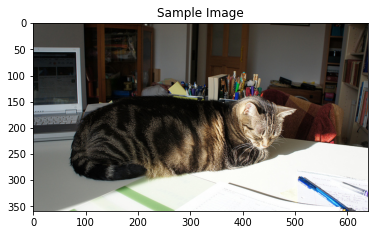

 a cat is sitting on a bed with a laptop computer .


In [ ]:
get_prediction()

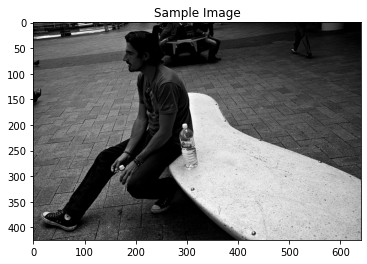

 a man is holding a cell phone in a field .


In [ ]:
get_prediction()

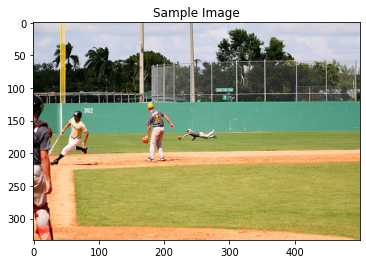

 a man is holding a tennis racket on a court .


In [ ]:
get_prediction()

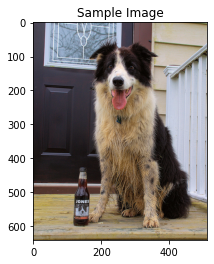

 a dog is sitting on a bench .


In [ ]:
get_prediction()

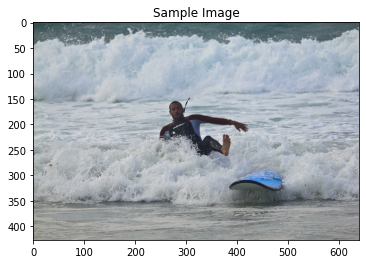

 a person is on a skateboard on a skateboard .


In [ ]:
get_prediction()